<a href="https://colab.research.google.com/github/Basoski/Python/blob/main/BinaryClassificationLog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import torch
import matplotlib.pyplot as plt
import random
import math

torch.manual_seed(42)

## Creating the dataset

In [162]:
from torch.distributions.normal import Normal

def gaussian(n_samples, mean, std):
  mean = torch.tensor(mean, dtype = torch.float32)
  std = torch.tensor(std, dtype=torch.float32)
  dist = Normal(mean, std)
  return dist.sample((n_samples, 2))  # .sample() takes a random variable belonging to the distribution defined. The tuple inside of it describes the dimension it needs to have. In this case, we will have a tensor of n_samples rows, each one has two values (random variables belonging to the distribution)

n_samples = 300

class0 = gaussian(n_samples, 13.8, 3.1)
class1 = gaussian(n_samples, 3.8, 1.0)

X = torch.cat([class0, class1], dim=0)
Y = torch.cat([torch.zeros(n_samples), torch.ones(n_samples)]).int()

## Plotting the dataset

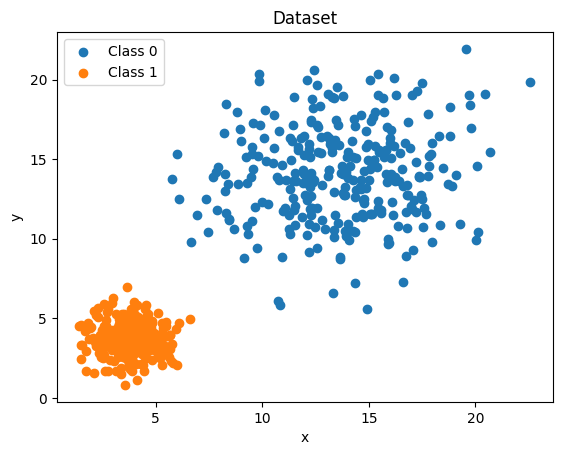

In [163]:
def plot_dataset(X,Y):
  for cl in torch.unique(Y):    # torch.unique retetrives the unique elements of the input tensor
    pts = X[Y == cl]
    plt.scatter(pts[:,0], pts[:,1], label = f"Class {int(cl)}")
  plt.legend()
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("Dataset")
  plt.show()

plot_dataset(X,Y)


## Costruzione del modello

In [164]:
import torch.nn as nn
class Logistic(nn.Module):
  def __init__(self, nClasses):
    super().__init__()
    self.linear = nn.Linear(nClasses, 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    logits = self.linear(x)
    return logits

model = Logistic(2)

## Training loop

In [165]:
def standardize_train_val(X_tr, X_val):
  mu = X_tr.mean(0,keepdim=True)
  std = X_tr.std(0, keepdim=True)
  return (X_tr - mu) / std, (X_val - mu) / std, mu, std

def train_one_split(model, X_tr, Y_tr, epochs=500, lr=1e-2):
  loss_function = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  for epoch in range(epochs):
    model.train()
    logits = model(X_tr)
    loss = loss_function(logits, Y_tr.float().unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 30 == 0:
      print(f"Epoch: {epoch} | train_loss = {loss}")
  return model



In [166]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # Import Line2D for proxy artist

def plot_decision_boundary(model, mu, std, X_all, Y_all, title=""):
    # griglia nello spazio originale
    x_min, x_max = X_all[:,0].min().item()-1, X_all[:,0].max().item()+1
    y_min, y_max = X_all[:,1].min().item()-1, X_all[:,1].max().item()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    grid_n = (grid - mu) / std  # stessa normalizzazione del fold

    with torch.no_grad():
        zz = torch.sigmoid(model(grid_n)).view(xx.shape).cpu().numpy()

    # scatter dei dati e frontiera p=0.5
    plt.figure()
    X0 = X_all[Y_all==0]; X1 = X_all[Y_all==1]
    plt.scatter(X0[:,0], X0[:,1], alpha=0.7, label="Classe 0")
    plt.scatter(X1[:,0], X1[:,1], alpha=0.7, label="Classe 1")
    cs = plt.contour(xx, yy, zz, levels=[0.5])

    # Use a proxy artist to add the contour line label to the legend
    proxy = Line2D([0], [0], linestyle='-', color='black', label='Decision boundary (p=0.5)')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(proxy)

    plt.legend(handles=handles, labels=labels); plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")
    plt.show()

Epoch: 0 | train_loss = 0.5120121836662292
Epoch: 30 | train_loss = 0.33758530020713806
Epoch: 60 | train_loss = 0.23752768337726593
Epoch: 90 | train_loss = 0.17863327264785767
Epoch: 120 | train_loss = 0.14132805168628693
Epoch: 150 | train_loss = 0.11601948738098145
Epoch: 180 | train_loss = 0.09789614379405975
Epoch: 210 | train_loss = 0.084361232817173
Epoch: 240 | train_loss = 0.07391151040792465
Epoch: 270 | train_loss = 0.06562445312738419
Epoch: 300 | train_loss = 0.05890617519617081
Epoch: 330 | train_loss = 0.053358711302280426
Epoch: 360 | train_loss = 0.04870626702904701
Epoch: 390 | train_loss = 0.044752202928066254
Epoch: 420 | train_loss = 0.04135278984904289
Epoch: 450 | train_loss = 0.03840077295899391
Epoch: 480 | train_loss = 0.035814475268125534

Fold 1 | test_loss = 0.0320943258702755



/tmp/ipython-input-296861091.py:29: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 2
  plt.legend(handles=handles, labels=labels); plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")


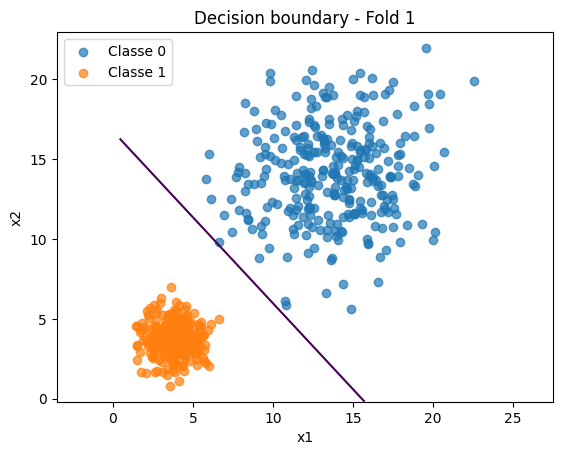

Epoch: 0 | train_loss = 1.0547577142715454
Epoch: 30 | train_loss = 0.7247340083122253
Epoch: 60 | train_loss = 0.5074950456619263
Epoch: 90 | train_loss = 0.3714890778064728
Epoch: 120 | train_loss = 0.285278856754303
Epoch: 150 | train_loss = 0.22819922864437103
Epoch: 180 | train_loss = 0.18850912153720856
Epoch: 210 | train_loss = 0.15967877209186554
Epoch: 240 | train_loss = 0.1379568874835968
Epoch: 270 | train_loss = 0.12108907848596573
Epoch: 300 | train_loss = 0.10765883326530457
Epoch: 330 | train_loss = 0.09673961251974106
Epoch: 360 | train_loss = 0.08770383149385452
Epoch: 390 | train_loss = 0.0801132470369339
Epoch: 420 | train_loss = 0.07365353405475616
Epoch: 450 | train_loss = 0.06809396296739578
Epoch: 480 | train_loss = 0.06326170265674591

Fold 2 | test_loss = 0.061049409210681915



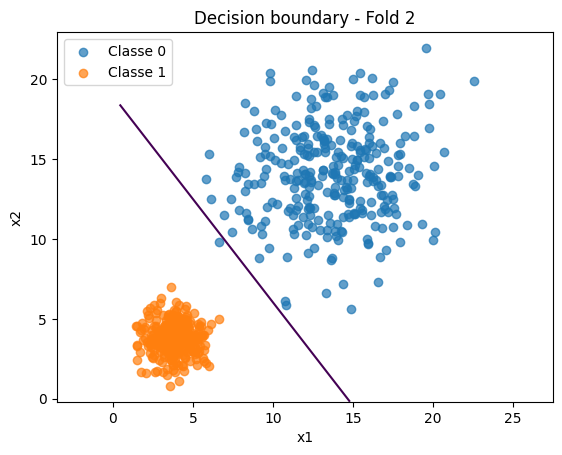

Epoch: 0 | train_loss = 0.7482360005378723
Epoch: 30 | train_loss = 0.5023075938224792
Epoch: 60 | train_loss = 0.351291686296463
Epoch: 90 | train_loss = 0.2606903612613678
Epoch: 120 | train_loss = 0.20363564789295197
Epoch: 150 | train_loss = 0.16540789604187012
Epoch: 180 | train_loss = 0.13837842643260956
Epoch: 210 | train_loss = 0.11841694265604019
Epoch: 240 | train_loss = 0.1031511127948761
Epoch: 270 | train_loss = 0.09114097058773041
Epoch: 300 | train_loss = 0.0814695805311203
Epoch: 330 | train_loss = 0.07352908700704575
Epoch: 360 | train_loss = 0.0669020339846611
Epoch: 390 | train_loss = 0.06129339709877968
Epoch: 420 | train_loss = 0.056489162147045135
Epoch: 450 | train_loss = 0.05233057588338852
Epoch: 480 | train_loss = 0.048697613179683685

Fold 3 | test_loss = 0.049276016652584076



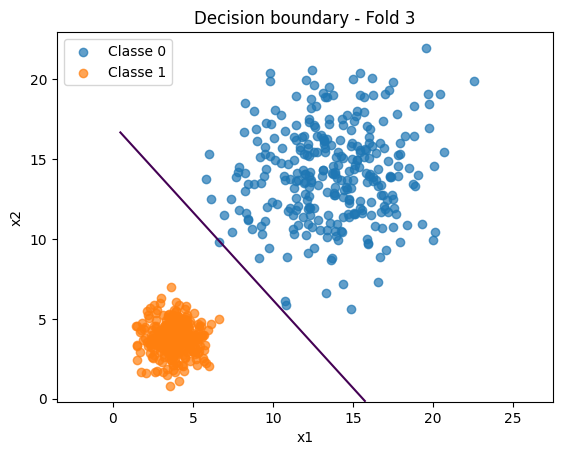

Epoch: 0 | train_loss = 1.0324195623397827
Epoch: 30 | train_loss = 0.6970453262329102
Epoch: 60 | train_loss = 0.4785451591014862
Epoch: 90 | train_loss = 0.34881457686424255
Epoch: 120 | train_loss = 0.26846015453338623
Epoch: 150 | train_loss = 0.2153695523738861
Epoch: 180 | train_loss = 0.17835946381092072
Epoch: 210 | train_loss = 0.15139584243297577
Epoch: 240 | train_loss = 0.1310262382030487
Epoch: 270 | train_loss = 0.11517265439033508
Epoch: 300 | train_loss = 0.10252589732408524
Epoch: 330 | train_loss = 0.09222733229398727
Epoch: 360 | train_loss = 0.08369375765323639
Epoch: 390 | train_loss = 0.07651695609092712
Epoch: 420 | train_loss = 0.07040347158908844
Epoch: 450 | train_loss = 0.06513754278421402
Epoch: 480 | train_loss = 0.06055726110935211

Fold 4 | test_loss = 0.04264366999268532



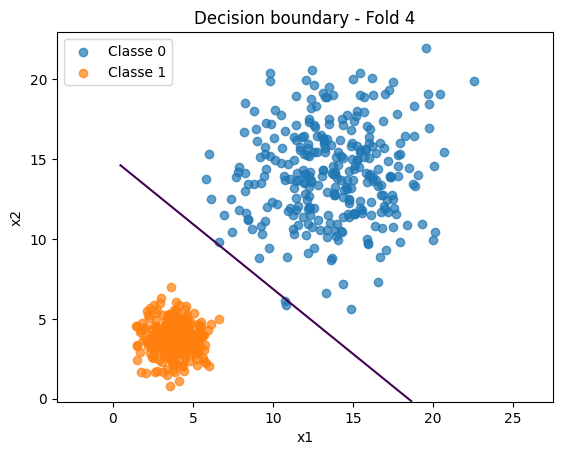

Epoch: 0 | train_loss = 0.5291038751602173
Epoch: 30 | train_loss = 0.34931305050849915
Epoch: 60 | train_loss = 0.2435368001461029
Epoch: 90 | train_loss = 0.18148137629032135
Epoch: 120 | train_loss = 0.14243192970752716
Epoch: 150 | train_loss = 0.11610352247953415
Epoch: 180 | train_loss = 0.09735103696584702
Epoch: 210 | train_loss = 0.08341084420681
Epoch: 240 | train_loss = 0.07269144058227539
Epoch: 270 | train_loss = 0.06422095000743866
Epoch: 300 | train_loss = 0.057376209646463394
Epoch: 330 | train_loss = 0.05174119397997856
Epoch: 360 | train_loss = 0.047028567641973495
Epoch: 390 | train_loss = 0.04303409159183502
Epoch: 420 | train_loss = 0.03960876911878586
Epoch: 450 | train_loss = 0.036641575396060944
Epoch: 480 | train_loss = 0.03404833376407623

Fold 5 | test_loss = 0.04807254299521446



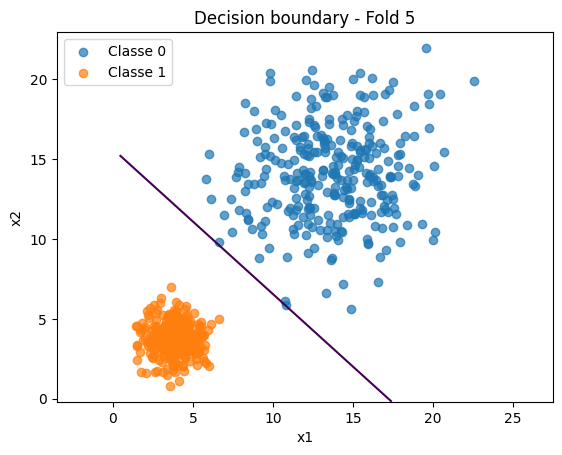

In [167]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
val_losses = []

for fold, (tr_idx, val_idx) in enumerate(kfold.split(X, Y), 1):
  X_tr, Y_tr = X[tr_idx], Y[tr_idx]
  X_val, Y_val = X[val_idx], Y[val_idx]

  X_tr_n, X_val_n, mu, std = standardize_train_val(X_tr, X_val)

  model = Logistic(2)
  model = train_one_split(model, X_tr_n, Y_tr)

  loss_function = nn.BCEWithLogitsLoss()
  model.eval()
  with torch.no_grad():
    val_logits = model(X_val_n)
    val_loss = loss_function(val_logits, Y_val.float().unsqueeze(1))
    val_prob = torch.sigmoid(val_logits).squeeze(1)
  val_losses.append(val_loss)
  print(f"\nFold {fold} | test_loss = {val_loss}\n")
  plot_decision_boundary(model, mu, std, X_all = X, Y_all=Y, title=f"Decision boundary - Fold {fold}")

